**Import des données / Lib**

In [32]:
# 📦 Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error, r2_score

df = pd.read_parquet('../data/prod/df_model_appart_2020.parquet.gz', engine='pyarrow')
# Calcul de la fréquence des communes
df.head()

,surface_reelle_bati,nombre_pieces_principales,latitude,longitude,has_dependance,nom_commune,prix_m2
0,62.0,3.0,46.198795,5.219443,True,Bourg-en-Bresse,2193.548340
1,47.0,2.0,46.307400,4.842984,True,Saint-Laurent-sur-Saône,1531.914917
2,46.0,2.0,46.205639,5.222975,False,Bourg-en-Bresse,1521.739136
3,60.0,2.0,46.208492,5.220961,True,Bourg-en-Bresse,583.333313
4,55.0,2.0,46.248257,5.130623,True,Polliat,2215.109619


**Random Forest**

In [ ]:
# --- Encodage boolean ---
df["has_dependance"] = df["has_dependance"].astype(int)

# --- Définir features de base et target ---
FEATURES_BASE = [
    "surface_reelle_bati",
    "nombre_pieces_principales",
    "latitude",
    "longitude",
    "has_dependance",
]

TARGET = "prix_m2"

X = df[FEATURES_BASE + ["nom_commune"]].copy()
y = df[TARGET]

# --- Split train/test AVANT feature engineering ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# --- Créer feature nb_ventes_commune sur TRAIN uniquement ---
commune_sales = (
    X_train.groupby("nom_commune")
           .size()
           .rename("nb_ventes_commune")
)

# --- Appliquer au train et au test ---
X_train = X_train.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

X_test = X_test.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

# --- Gérer communes jamais vues dans le test ---
median_sales = commune_sales.median()

X_train["nb_ventes_commune"] = X_train["nb_ventes_commune"].fillna(median_sales)
X_test["nb_ventes_commune"] = X_test["nb_ventes_commune"].fillna(median_sales)

# --- Sélection finale des features ---
FEATURES_FINAL = FEATURES_BASE + ["nb_ventes_commune"]
X_train_final = X_train[FEATURES_FINAL]
X_test_final = X_test[FEATURES_FINAL]

# --- Entraînement Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=22,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_final, y_train)

# --- Prédictions et évaluation ---
y_pred = rf_model.predict(X_test_final)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest")
print("RMSE :", rmse)
print("R2   :", r2)

# --- Importance des features ---
importances = pd.Series(
    rf_model.feature_importances_,
    index=FEATURES_FINAL
).sort_values(ascending=False)

print("\nImportance des features :")
print(importances)

Random Forest
RMSE : 32.48448407869209
R2   : 0.8334907754404861

Importance des features :
latitude                     0.654240
longitude                    0.163473
nb_ventes_commune            0.147776
surface_reelle_bati          0.028748
has_dependance               0.003677
nombre_pieces_principales    0.002086
dtype: float64


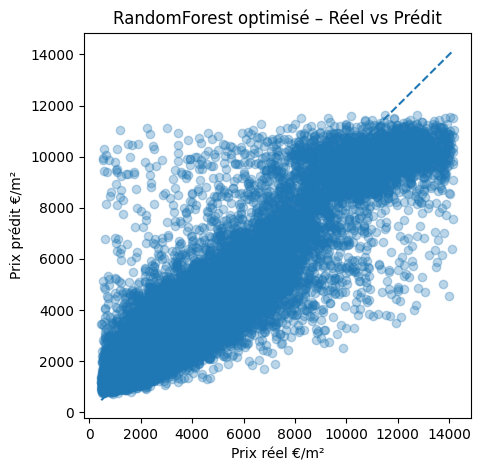

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test_real, y_pred_real, alpha=0.3)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    linestyle="--"
)
plt.xlabel("Prix réel €/m²")
plt.ylabel("Prix prédit €/m²")
plt.title("RandomForest optimisé – Réel vs Prédit")
plt.show()

**Import des données / Lib**

**GradientBoostingRegressor**

In [ ]:
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

rmse_gb = root_mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting")
print("RMSE :", rmse_gb)
print("R2   :", r2_gb)

Gradient Boosting
RMSE : 1241.5591539744707
R2   : 0.7695008987873689


**LightGBM**

In [ ]:

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

rmse_lgb = root_mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LightGBM")
print("RMSE :", rmse_lgb)
print("R2   :", r2_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 152417, number of used features: 5
[LightGBM] [Info] Start training from score 3691.475758
LightGBM
RMSE : 1138.5413028727028
R2   : 0.8061650957966005
